In [1]:
import numpy as np
from matplotlib import pyplot as plt
# Core configuration & plotting settings
from qspectro2d.config import *  # provides CONFIG and mpl settings
from qspectro2d.core.atomic_system.system_class import AtomicSystem
from qutip import *

from project_config.paths import FIGURES_TESTS_DIR
name_plot_folder = "test_N_atoms_geometry"
custom_dir = FIGURES_TESTS_DIR / name_plot_folder

from plotstyle import COLORS, MARKERS, LINE_STYLES, FONT_SIZE, LATEX_DOC_WIDTH, set_size, save_fig, latex_available, format_sci_notation, init_style
init_style()

### Helper printing utilities
def show_basic_info(title: str, system):
    print(f"\n=== {title} ===")
    print(f"n_atoms: {system.n_atoms}")
    print("frequencies (cm^-1):", system.frequencies_cm)
    print("dip moments:", system.dip_moments)
    print("dipole operator in eigenbasis:", system.dipole_op.tidyup().full().real)
    if system.n_atoms <= 12:
        print("Hamiltonian matrix (fs^-1 units / ħ incorporated):")
        print(system.hamiltonian.tidyup().full().real)

In [2]:
### 1. Single atom system
single = AtomicSystem(n_atoms=1, frequencies_cm=[16000.0], dip_moments=[1.0])
show_basic_info("Single Atom", single)
basis_states = single.eigenstates[1]
#print("eigenvectors", basis_states)
#U = Qobj(np.column_stack([e.full() for e in basis_states]))
#A = single.deph_op_i(1)

#A_new = U.dag() * A * U
#print("dephasing operator in fock basis vs eigenbasis:", A, A_new)


=== Single Atom ===
n_atoms: 1
frequencies (cm^-1): [16000.0]
dip moments: [1.0]
dipole operator in eigenbasis: [[0. 1.]
 [1. 0.]]
Hamiltonian matrix (fs^-1 units / ħ incorporated):
[[0.         0.        ]
 [0.         3.01391833]]


In [3]:
### 2. Dimer with coupling
# Simple two-site system with modest detuning and coupling
dimer1 = AtomicSystem(
    n_atoms=2,
    max_excitation=1,  # single-excitation manifold
    frequencies_cm=[16360.0, 15640.0],
    dip_moments=[1.0, 1.2],
    coupling_cm=10.0,)
show_basic_info("Dimer (2 atoms {1})", dimer1)

### 2. Dimer with coupling
# Simple two-site system with modest detuning and coupling
dimer2 = AtomicSystem(
    n_atoms=2,
    max_excitation=2,  # double-excitation manifold
    frequencies_cm=[16360.0, 15640.0],
    dip_moments=[1.0, 1.2],
    coupling_cm=1000.0,
)
show_basic_info("Dimer (2 atoms {2})", dimer2)

basis_states = dimer2.eigenstates[1]
print("eigenvectors", basis_states)
U = Qobj(np.column_stack([e.full() for e in basis_states]))
A = dimer2.deph_op_i(1)

A_new = U * A * U.dag() # transform back into the site basis
print("dephasing operator in fock basis vs eigenbasis:", A, A_new)


=== Dimer (2 atoms {1}) ===
n_atoms: 2
frequencies (cm^-1): [16360.0, 15640.0]
dip moments: [1.0, 1.2]
dipole operator in eigenbasis: [[0.  1.  1.2]
 [1.  0.  0. ]
 [1.2 0.  0. ]]
Hamiltonian matrix (fs^-1 units / ħ incorporated):
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.08173149e+00 2.26043875e-03]
 [0.00000000e+00 2.26043875e-03 2.94610517e+00]]

=== Dimer (2 atoms {2}) ===
n_atoms: 2
frequencies (cm^-1): [16360.0, 15640.0]
dip moments: [1.0, 1.2]
dipole operator in eigenbasis: [[0.  1.  1.2 0. ]
 [1.  0.  0.  1.2]
 [1.2 0.  0.  1. ]
 [0.  1.2 1.  0. ]]
Hamiltonian matrix (fs^-1 units / ħ incorporated):
[[0.         0.         0.         0.        ]
 [0.         3.08173149 0.22604387 0.        ]
 [0.         0.22604387 2.94610517 0.        ]
 [0.         0.         0.         6.02783666]]
eigenvectors [Quantum object: dims=[[4], [1]], shape=(4, 1), type='ket', dtype=Dense
 Qobj data =
 [[1.]
  [0.]
  [0.]
  [0.]]
 Quantum object: dims=[[4], [1]], shape=(4, 

In [4]:
dip = dimer2.dipole_op
print("dipole operator:", dip)

num_op = dimer2.number_op
print("number operator:", num_op.tidyup())

# Test the new mathematical mapping functions
from qspectro2d.core.atomic_system.system_class import pair_to_index, index_to_pair
N = dimer2.n_atoms
if dimer2.max_excitation == 2:
    print("Double-excitation mappings:")
    for i in range(1, N):
        for j in range(i + 1, N + 1):
            idx = pair_to_index(i, j, N)
            i_back, j_back = index_to_pair(idx, N)
            print(f"  |{i},{j}> -> index {idx} -> back to ({i_back},{j_back})")

dipole operator: Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.  1.  1.2 0. ]
 [1.  0.  0.  1.2]
 [1.2 0.  0.  1. ]
 [0.  1.2 1.  0. ]]
number operator: Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 2.]]
Double-excitation mappings:
  |1,2> -> index 4 -> back to (1,2)


In [5]:
def rwa_unitary(num_op: Qobj, omega_L: float, t: float) -> Qobj:
    """Return the time dependent transformation into the rotating frame.
    U(t) = exp(-i omega_L t N) where N = num_op.
    """
    return (-1j * omega_L * t * num_op).expm()

def rwa_unitary_derivative(num_op: Qobj, omega_L: float, t: float) -> Qobj:
    """Analytic time derivative dU/dt = -i omega_L N U (since [N, U]=0)."""
    U = rwa_unitary(num_op, omega_L, t)
    return -1j * omega_L * num_op * U

def finite_diff_derivative(num_op: Qobj, omega_L: float, t: float, h: float = 1e-7) -> Qobj:
    """Central finite-difference numerical derivative of U(t)."""
    Up = rwa_unitary(num_op, omega_L, t + h)
    Um = rwa_unitary(num_op, omega_L, t - h)
    return (Up - Um) / (2 * h)

def to_rotating_frame(op: Qobj, num_op: Qobj, omega_L: float, t: float) -> Qobj:
    """Transform operator to rotating frame at frequency omega_L.
    O_RF = U^† O U - i U^† (dU/dt)
    """
    U  = rwa_unitary(num_op, omega_L, t)
    dU = finite_diff_derivative(num_op, omega_L, t)
    op_rot = U.dag() * op * U - 1j * U.dag() * dU
    return op_rot

# --- Verify derivative correctness numerically ---
omega_L = 1.0
N_op = dimer2.number_op
for t_test in [0.0, 0.1, 0.5, 1.0, 10, 100, 1000, 10000]:
    dU_an  = rwa_unitary_derivative(N_op, omega_L, t_test)
    dU_num = finite_diff_derivative(N_op, omega_L, t_test, h=1e-7)
    err = (dU_an - dU_num).norm()
    rel = err / max(dU_an.norm(), 1e-14)
    print(f"t={t_test:5.2f}  abs_err={err:.3e}  rel_err={rel:.3e}")

psi_rotating = to_rotating_frame(psi_diag, dimer2.number_op, omega_L, 100)
psi_rotating

H = dimer2.hamiltonian
evals, evecs = H.eigenstates()
H_diag = Qobj(np.diag(evals), dims=H.dims)   # diagonal Hamiltonian
H_rot = H_diag - omega_L * dimer2.number_op
print("Hamiltonian in lab frame (diag):", H_diag.tidyup())
print("1. Hamiltonian in rotating frame (simple shift):", H_rot.tidyup())
H_rot2 = to_rotating_frame(H_diag, dimer2.number_op, omega_L, 100)
print("2. Hamiltonian in rotating frame (explicit transform at t=100):", H_rot2.tidyup())

t= 0.00  abs_err=1.665e-14  rel_err=4.163e-15
t= 0.10  abs_err=1.304e-09  rel_err=3.259e-10
t= 0.50  abs_err=2.845e-09  rel_err=7.112e-10
t= 1.00  abs_err=2.819e-09  rel_err=7.046e-10
t=10.00  abs_err=2.436e-08  rel_err=6.091e-09
t=100.00  abs_err=2.380e-07  rel_err=5.950e-08
t=1000.00  abs_err=1.374e-06  rel_err=3.435e-07
t=10000.00  abs_err=3.046e-05  rel_err=7.615e-06


NameError: name 'psi_diag' is not defined

In [9]:
### 3 atoms
three_at = AtomicSystem(n_atoms=3,
                        frequencies_cm=[16000.0, 16500.0, 17000.0],
                        dip_moments=[1.0, 1.0, 1.0],
                        max_excitation=2,  # single-excitation manifold
                        coupling_cm=200.0)
show_basic_info("Three Atoms", three_at)
dip = three_at.dipole_op
print("dipole operator:", dip)

num_op = three_at.number_op
print("number operator:", num_op.tidyup())

# Test mathematical mapping functions for 3 atoms (no double excitations in this case)
print("System dimension:", three_at.dimension)
print("Max excitation level:", three_at.max_excitation)

# Test the new mathematical mapping functions
from qspectro2d.core.atomic_system.system_class import pair_to_index, index_to_pair
N = three_at.n_atoms
if three_at.max_excitation == 2:
    print("Double-excitation mappings:")
    for i in range(1, N):
        for j in range(i + 1, N + 1):
            idx = pair_to_index(i, j, N)
            i_back, j_back = index_to_pair(idx, N)
            print(f"  |{i},{j}> -> index {idx} -> back to ({i_back},{j_back})")

coupling_op = three_at.coupling_op
coupling_op

num_op = three_at.number_op
num_op.tidyup()


=== Three Atoms ===
n_atoms: 3
frequencies (cm^-1): [16000.0, 16500.0, 17000.0]
dip moments: [1.0, 1.0, 1.0]
dipole operator in eigenbasis: [[0. 1. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0.]]
Hamiltonian matrix (fs^-1 units / ħ incorporated):
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.01391833e+00 3.76739791e-02 4.70924739e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.76739791e-02 3.10810328e+00 3.76739791e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.70924739e-03 3.76739791e-02 3.20228822e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.12202160e+00 3.76739791e-02 4.70924739e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.76739791e-02 6.21620655

Quantum object: dims=[[7], [7]], shape=(7, 7), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0. 0. 2.]]

In [22]:
i_atom = 1
j_atom = 2
idx = pair_to_index(i_atom, j_atom, three_at.n_atoms)
Li = three_at._basis[i_atom] * three_at._basis[idx].dag()
op_ij_i = Li + Li.dag()
print("Li:", op_ij_i)
Lj = three_at._basis[j_atom] * three_at._basis[idx].dag()
op_ij_j = Lj + Lj.dag()
print("Lj:", op_ij_j)
decay_op = op_ij_i + op_ij_j
print("decay_op:", decay_op)

Li: Quantum object: dims=[[7], [7]], shape=(7, 7), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
Lj: Quantum object: dims=[[7], [7]], shape=(7, 7), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
decay_op: Quantum object: dims=[[7], [7]], shape=(7, 7), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [11]:
three_at.to_eigenbasis(num_op.tidyup())

Quantum object: dims=[[7], [7]], shape=(7, 7), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -1.52400151e-16  4.64018478e-17
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.52400151e-16  1.00000000e+00  3.37543040e-17
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.64018478e-17  3.37543040e-17  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.00000000e+00 -3.24741677e-16  1.43040068e-16]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -3.24741677e-16  2.00000000e+00 -3.00727773e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.43040068e-16 -3.00727773e-18  2.00000000e+00]]

In [12]:
three_at = AtomicSystem(n_atoms=3,
                        frequencies_cm=[16000.0, 16500.0, 17000.0],
                        dip_moments=[1.0, 1.0, 1.0],
                        max_excitation=1,  # single-excitation manifold
                        coupling_cm=200.0)

coupling_op = three_at.coupling_op
coupling_op


Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.         0.03767398 0.00470925]
 [0.         0.03767398 0.         0.03767398]
 [0.         0.00470925 0.03767398 0.        ]]

In [1]:
### 3. 4-atom system (double-excitation manifold) with dipole-dipole coupling
four_at = AtomicSystem(
    n_atoms=4,
    frequencies_cm=[16000 + 5*i for i in range(4)],
    dip_moments=[1.0]*4,
    coupling_cm=300.0,
    max_excitation=2,
)
basis_states = four_at.eigenstates[1]
print("eigenvectors", basis_states)
U = Qobj(np.column_stack([e.full() for e in basis_states]))
A = four_at.deph_op_i(1)

A_new = U.dag() * A * U
print("dephasing operator in fock basis vs eigenbasis:", A, A_new)

dip = four_at.dipole_op
print("dipole operator:", dip)

num_op = four_at.number_op
print("number operator:", num_op.tidyup())

# Test the new mathematical mapping functions for 4 atoms
from qspectro2d.core.atomic_system.system_class import pair_to_index, index_to_pair
N = four_at.n_atoms
if four_at.max_excitation == 2:
    print("Double-excitation mappings:")
    for i in range(1, N):
        for j in range(i + 1, N + 1):
            idx = pair_to_index(i, j, N)
            i_back, j_back = index_to_pair(idx, N)
            print(f"  |{i},{j}> -> index {idx} -> back to ({i_back},{j_back})")

coupling_op = four_at.coupling_op
coupling_op

NameError: name 'AtomicSystem' is not defined

In [ ]:
### 3. 4-atom system (double-excitation manifold) with dipole-dipole coupling
four_at = AtomicSystem(
    n_atoms=4,
    frequencies_cm=[16000 + 5*i for i in range(4)],
    dip_moments=[1.0]*4,
    coupling_cm=300.0,
    max_excitation=1,
)
coupling_op = four_at.coupling_op
coupling_op
H = four_at.hamiltonian
H

Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 3.01391833e+00 5.65109687e-02 7.06387108e-03
  2.09299884e-03]
 [0.00000000e+00 5.65109687e-02 3.01486018e+00 5.65109687e-02
  7.06387108e-03]
 [0.00000000e+00 7.06387108e-03 5.65109687e-02 3.01580203e+00
  5.65109687e-02]
 [0.00000000e+00 2.09299884e-03 7.06387108e-03 5.65109687e-02
  3.01674388e+00]]

In [ ]:
### 4. 12-atom cylindrical geometry (2 chains x 6 rings) with 1/r^3 couplings
cyl1 = AtomicSystem(
    n_atoms=12,
    n_chains=2,  # 6 rings, 2 chains
    frequencies_cm=[16000.0]*12,
    dip_moments=[1.0]*12,
    coupling_cm=200.0,  # used as default prefactor if not specified
)
# Place on cylinder and build couplings
#show_basic_info("Cylindrical Geometry (12 atoms)", cyl1)
#print("Positions (arbitrary units):\n", cyl1._positions)
#mat = cyl1.coupling_matrix_cm
#print("Coupling matrix (cm^-1):\n", mat)
dip = cyl1.dipole_op
print("dipole operator:", dip)

num_op = cyl1.number_op
print("number operator:", num_op.tidyup())

# No double excitations for this system (max_excitation=1 by default)
print("System dimension:", cyl1.dimension)
print("Max excitation level:", cyl1.max_excitation)

dipole operator: Quantum object: dims=[[13], [13]], shape=(13, 13), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
number operator: Quantum object: dims=[[13], [13]], shape=(13, 13), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 

[WindowsPath('C:/Users/leopo/.vscode/master_thesis/figures/figures_from_python/tests/test_N_atoms_geometry/cylindrical_positions.png')]

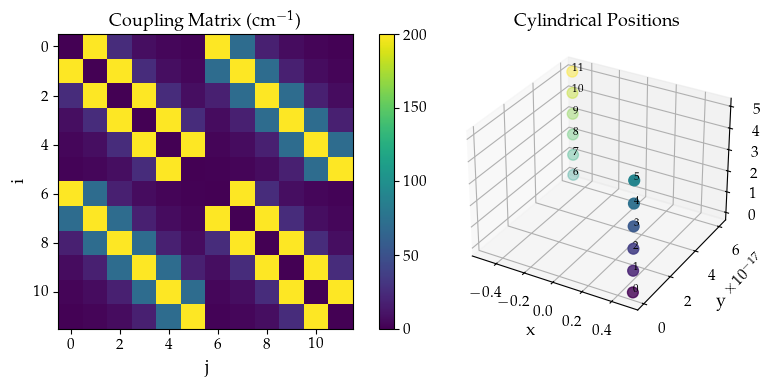

In [ ]:
### Visualization: Coupling matrix heatmap & 3D positions
fig = plt.figure(figsize=(12,4))

# Coupling matrix heatmap
ax1 = fig.add_subplot(1,2,1)
im = ax1.imshow(cyl1.coupling_matrix_cm, cmap='viridis')
ax1.set_title("Coupling Matrix (cm$^{-1}$)")
ax1.set_xlabel("j")
ax1.set_ylabel("i")
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# 3D positions
ax2 = fig.add_subplot(1,2,2, projection='3d')
pos = cyl1._positions
ax2.scatter(pos[:,0], pos[:,1], pos[:,2], c=np.arange(len(pos)), cmap='viridis', s=60)
for idx, (x,y,z) in enumerate(pos):
    ax2.text(x, y, z, f"{idx}", fontsize=8)
ax2.set_title("Cylindrical Positions")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
save_fig(fig, custom_dir / "cylindrical_positions")

[WindowsPath('C:/Users/leopo/.vscode/master_thesis/figures/figures_from_python/tests/test_N_atoms_geometry/eigen_spectrum_single_excitation.png')]

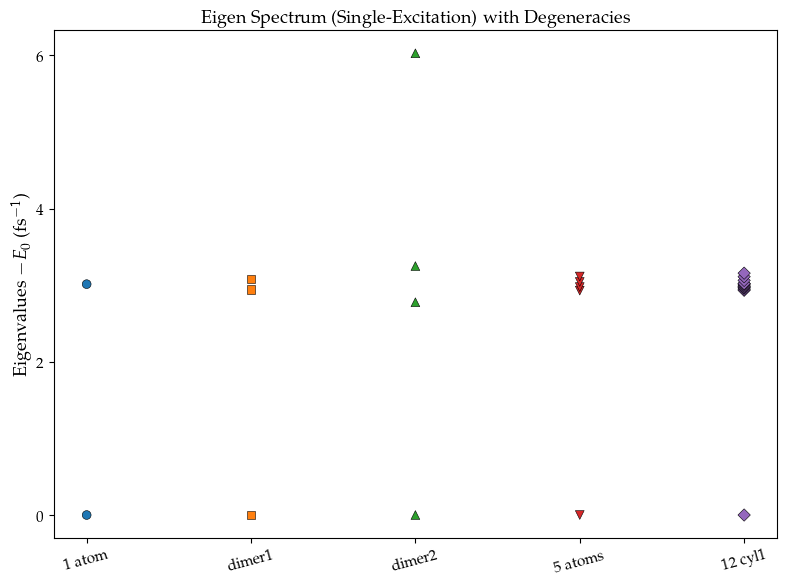

In [ ]:
### 5. Energy spectrum comparison plot (eigenvalues with degeneracy)
# Assemble systems in an ordered mapping for automatic iteration
systems_map = {
    "1 atom": single,
    "dimer1": dimer1,
    "dimer2": dimer2,
    "5 atoms": four_at,
    "12 cyl1": cyl1,
}

# Group nearly-equal eigenvalues (degeneracy) helper
def group_levels(evals: np.ndarray, atol: float = 1e-10):
    vals_sorted = np.sort(evals)
    uniq = []
    counts = []
    for e in vals_sorted:
        if not uniq or abs(e - uniq[-1]) > atol:
            uniq.append(e)
            counts.append(1)
        else:
            counts[-1] += 1
    return np.array(uniq), np.array(counts)

plt.figure()
handles = []
for x, (label, sys) in enumerate(systems_map.items()):
    evals = sys.eigenstates[0]
    evals_shift = evals - evals.min()  # shift so ground level = 0
    uniq, counts = group_levels(evals_shift)

    color     = COLORS[x % len(COLORS)]
    marker    = MARKERS[x % len(MARKERS)]

    # Marker size encodes degeneracy
    sizes = 40 + 70*(counts-1)  # base size + additive per extra state
    plt.scatter(
        np.full_like(uniq, x, dtype=float),
        uniq,
        s=sizes,
        color=color,
        marker=marker,
        edgecolors='k',
        linewidths=0.4,
        label=label,
        zorder=3,
    )

    # Annotate degeneracy if >1; small horizontal jitter for readability
    for u, cnt in zip(uniq, counts):
        if cnt > 1:
            plt.text(x + 0.08, u, f"×{cnt}", va='center', ha='left', fontsize=8)

plt.ylabel(r'Eigenvalues $- E_0$ (fs$^{-1}$)')
plt.xticks(range(len(systems_map)), list(systems_map.keys()), rotation=15)
plt.title('Eigen Spectrum (Single-Excitation) with Degeneracies')
plt.legend(handles=handles, frameon=False, ncol=len(systems_map))
save_fig(plt.gcf(), custom_dir / "eigen_spectrum_single_excitation")


=== Cylindrical Geometry (30 atoms) ===
n_atoms: 30
frequencies (cm^-1): [16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0, 16000.0]
dip moments: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dipole operator in eigenbasis: [[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

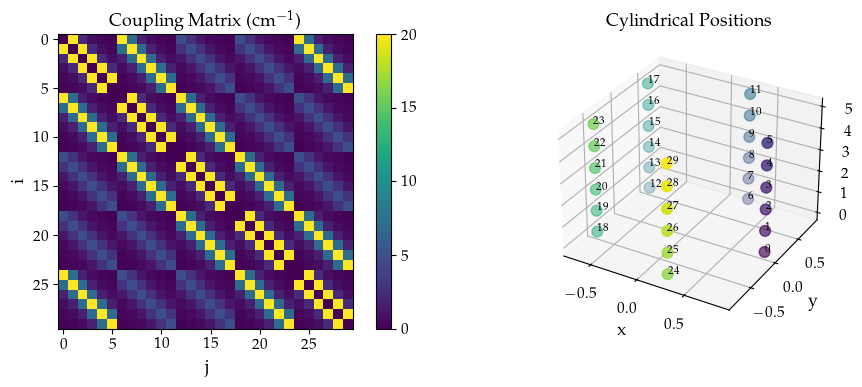

[WindowsPath('C:/Users/leopo/.vscode/master_thesis/figures/figures_from_python/tests/test_N_atoms_geometry/eigen_spectrum_single_excitation_30_at.png')]

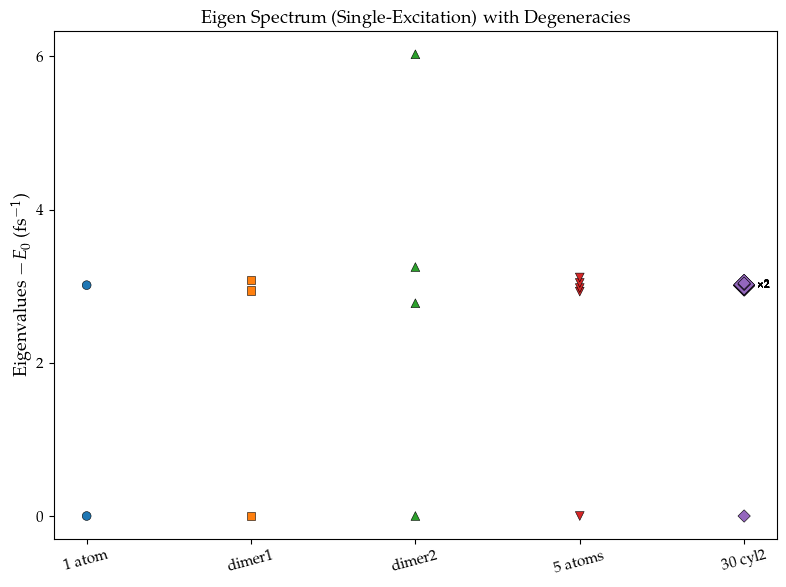

In [ ]:
### 4. 12-atom cylindrical geometry (2 chains x 3 rings) with 1/r^3 couplings
cyl2 = AtomicSystem(
    n_atoms=30,
    n_chains=5,  # 6 rings, 5 chains
    frequencies_cm=[16000.0]*30,
    dip_moments=[1.0]*30,
    max_excitation=1,
    coupling_cm=20.0,  # used as default prefactor if not specified
)
# Place on cylinder and build couplings
show_basic_info("Cylindrical Geometry (30 atoms)", cyl2)
print("Positions (arbitrary units):\n", cyl2._positions)
mat = cyl2.coupling_matrix_cm
print("Coupling matrix (cm^-1):\n", mat)

### Visualization: Coupling matrix heatmap & 3D positions
fig = plt.figure(figsize=(12,4))

# Coupling matrix heatmap
ax1 = fig.add_subplot(1,2,1)
im = ax1.imshow(mat, cmap='viridis')
ax1.set_title("Coupling Matrix (cm$^{-1}$)")
ax1.set_xlabel("j")
ax1.set_ylabel("i")
plt.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)

# 3D positions
ax2 = fig.add_subplot(1,2,2, projection='3d')
pos = cyl2._positions
ax2.scatter(pos[:,0], pos[:,1], pos[:,2], c=np.arange(len(pos)), cmap='viridis', s=60)
for idx, (x,y,z) in enumerate(pos):
    ax2.text(x, y, z, f"{idx}", fontsize=8)
ax2.set_title("Cylindrical Positions")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
plt.tight_layout()
save_fig(fig, custom_dir / "cylindrical_positions_30_at")
plt.show()

### 5. Energy spectrum comparison plot (eigenvalues with degeneracy)
# =============================
# DEGENERACY-AWARE PLOT (auto-configured: no manual systems/labels/colors lists)
# =============================
# Assemble systems in an ordered mapping for automatic iteration
systems_map = {
    "1 atom": single,
    "dimer1": dimer1,
    "dimer2": dimer2,
    "5 atoms": four_at,
    "30 cyl2": cyl2,
}

# Group nearly-equal eigenvalues (degeneracy) helper
def group_levels(evals: np.ndarray, atol: float = 1e-10):
    vals_sorted = np.sort(evals)
    uniq = []
    counts = []
    for e in vals_sorted:
        if not uniq or abs(e - uniq[-1]) > atol:
            uniq.append(e)
            counts.append(1)
        else:
            counts[-1] += 1
    return np.array(uniq), np.array(counts)

plt.figure()

handles = []
for x, (label, sys) in enumerate(systems_map.items()):
    evals = sys.eigenstates[0]
    evals_shift = evals - evals.min()  # shift so ground level = 0
    uniq, counts = group_levels(evals_shift)

    color     = COLORS[x % len(COLORS)]
    marker    = MARKERS[x % len(MARKERS)]

    # Marker size encodes degeneracy
    sizes = 40 + 70*(counts-1)  # base size + additive per extra state
    plt.scatter(
        np.full_like(uniq, x, dtype=float),
        uniq,
        s=sizes,
        color=color,
        marker=marker,
        edgecolors='k',
        linewidths=0.4,
        label=label,
        zorder=3,
    )

    # Annotate degeneracy if >1; small horizontal jitter for readability
    for u, cnt in zip(uniq, counts):
        if cnt > 1:
            plt.text(x + 0.08, u, f"×{cnt}", va='center', ha='left', fontsize=8)

plt.ylabel(r'Eigenvalues $- E_0$ (fs$^{-1}$)')
plt.xticks(range(len(systems_map)), list(systems_map.keys()), rotation=15)
plt.title('Eigen Spectrum (Single-Excitation) with Degeneracies')
plt.legend(handles=handles, frameon=False, ncol=len(systems_map))
plt.tight_layout()
save_fig(plt.gcf(), custom_dir / "eigen_spectrum_single_excitation_30_at")

In [ ]:
from qutip import *
from qspectro2d.core.simulation import SimulationConfig, SimulationModuleOQS
def redfield_paper(sim_oqs: SimulationModuleOQS) -> Qobj:
    """Dispatcher selecting appropriate implementation based on n_atoms."""
    n_atoms = sim_oqs.system.n_atoms
    if n_atoms == 1:
        return _redfield_paper_1atom(sim_oqs)
    if n_atoms == 2:
        return _redfield_paper_2atom(sim_oqs)
    raise ValueError("Only n_atoms=1 or 2 are supported.")


def _redfield_paper_1atom(sim_oqs: SimulationModuleOQS) -> Qobj:
    """Redfield tensor for a single 2-level system."""
    from qspectro2d.core.bath_system.bath_fcts import bath_to_rates

    size = 2
    idx_00 = stacked_index(size, 0, 0)
    idx_01 = stacked_index(size, 0, 1)
    idx_10 = stacked_index(size, 1, 0)
    idx_11 = stacked_index(size, 1, 1)

    w0 = sim_oqs.system._frequencies_fs[0]
    deph_rate_pure = bath_to_rates(sim_oqs.bath, mode="deph")
    down_rate, up_rate = bath_to_rates(sim_oqs.bath, w0, mode="decay")
    deph_rate_tot = deph_rate_pure + 0.5 * (down_rate + up_rate)

    R = np.zeros((size * size, size * size), dtype=complex)
    R[idx_10, idx_10] = -deph_rate_tot
    R[idx_01, idx_01] = -deph_rate_tot
    R[idx_00, idx_00] = -up_rate
    R[idx_00, idx_11] = down_rate
    R[idx_11, idx_00] = up_rate
    R[idx_11, idx_11] = -down_rate
    return Qobj(R, dims=[[[2], [2]], [[2], [2]]])

def _redfield_paper_2atom(sim_oqs: SimulationModuleOQS) -> Qobj:
    """Redfield tensor for a coupled dimer (n_atoms=2)."""
    size = 4
    idx_00 = stacked_index(size, 0, 0)
    idx_01 = stacked_index(size, 0, 1)
    idx_02 = stacked_index(size, 0, 2)
    idx_03 = stacked_index(size, 0, 3)
    idx_10 = stacked_index(size, 1, 0)
    idx_11 = stacked_index(size, 1, 1)
    idx_12 = stacked_index(size, 1, 2)
    idx_13 = stacked_index(size, 1, 3)
    idx_20 = stacked_index(size, 2, 0)
    idx_21 = stacked_index(size, 2, 1)
    idx_22 = stacked_index(size, 2, 2)
    idx_23 = stacked_index(size, 2, 3)
    idx_30 = stacked_index(size, 3, 0)
    idx_31 = stacked_index(size, 3, 1)
    idx_32 = stacked_index(size, 3, 2)
    idx_33 = stacked_index(size, 3, 3)

    R = np.zeros((size * size, size * size), dtype=complex)
    omega_laser = sim_oqs.laser._carrier_freq_fs

    # One-excitation coherences
    term = -1j * (
        sim_oqs.system.omega_ij(1, 0) - omega_laser
    ) - sim_oqs.sb_coupling.Gamma_big_ij(1, 0)
    R[idx_10, idx_10] = term
    R[idx_01, idx_01] = np.conj(term)
    term = -1j * (
        sim_oqs.system.omega_ij(2, 0) - omega_laser
    ) - sim_oqs.sb_coupling.Gamma_big_ij(2, 0)
    R[idx_20, idx_20] = term
    R[idx_02, idx_02] = np.conj(term)

    # Double-excited coherences
    term = -1j * (
        sim_oqs.system.omega_ij(3, 0) - 2 * omega_laser
    ) - sim_oqs.sb_coupling.Gamma_big_ij(3, 0)
    R[idx_30, idx_30] = term
    R[idx_03, idx_03] = np.conj(term)

    # Cross-coherences
    term = -1j * sim_oqs.system.omega_ij(1, 2) - sim_oqs.sb_coupling.Gamma_big_ij(1, 2)
    R[idx_12, idx_12] = term
    R[idx_21, idx_21] = np.conj(term)
    term = -1j * (
        sim_oqs.system.omega_ij(3, 1) - omega_laser
    ) - sim_oqs.sb_coupling.Gamma_big_ij(3, 1)
    R[idx_31, idx_31] = term
    R[idx_13, idx_13] = np.conj(term)
    term = -1j * (
        sim_oqs.system.omega_ij(3, 2) - omega_laser
    ) - sim_oqs.sb_coupling.Gamma_big_ij(3, 2)
    R[idx_32, idx_32] = term
    R[idx_23, idx_23] = np.conj(term)

    # Populations
    R[idx_11, idx_11] = -sim_oqs.sb_coupling.Gamma_big_ij(1, 1)
    R[idx_11, idx_22] = sim_oqs.sb_coupling.gamma_small_ij(1, 2)
    R[idx_22, idx_22] = -sim_oqs.sb_coupling.Gamma_big_ij(2, 2)
    R[idx_22, idx_11] = sim_oqs.sb_coupling.gamma_small_ij(2, 1)
    R[idx_33, :] = -R[idx_00, :] - R[idx_11, :] - R[idx_22, :]

    return Qobj(R, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]])


In [ ]:
from types import SimpleNamespace
import numpy as np
from qutip import Qobj, stacked_index
from qspectro2d.core.simulation.redfield_paper import redfield_paper
from qspectro2d.config import create_base_sim_oqs

args = SimpleNamespace(t_coh=5.0, t_wait=0.0, t_det_max=10.0, dt=0.5)

sim_oqs, time_cut = create_base_sim_oqs(args)
print(redfield_paper(sim_oqs))

size = 2
idx_00 = stacked_index(size, 0, 0)
idx_01 = stacked_index(size, 0, 1)
idx_10 = stacked_index(size, 1, 0)
idx_11 = stacked_index(size, 1, 1)
print(idx_00, idx_01, idx_10, idx_11)
R = np.zeros((size * size, size * size), dtype=complex)

🔧 Creating base simulation configuration...
🔎 Validating configuration...


AttributeError: 'AtomicSystem' object has no attribute 'basis'

In [ ]:
from types import SimpleNamespace
import numpy as np
from qutip import Qobj, stacked_index
from qspectro2d.core.simulation.redfield_paper import redfield_paper
from qspectro2d.config import create_base_sim_oqs

args = SimpleNamespace(t_coh=5.0, t_wait=0.0, t_det_max=10.0, dt=0.5)

sim_oqs, time_cut = create_base_sim_oqs(args)
print(redfield_paper(sim_oqs))

size = 2
idx_00 = stacked_index(size, 0, 0)
idx_01 = stacked_index(size, 0, 1)
idx_10 = stacked_index(size, 1, 0)
idx_11 = stacked_index(size, 1, 1)
print(idx_00, idx_01, idx_10, idx_11)
R = np.zeros((size * size, size * size), dtype=complex)

🔧 Creating base simulation configuration...
🔎 Validating configuration...
🔍 Validating solver...


🔧 Creating base simulation configuration...
🔎 Validating configuration...
🔍 Validating solver...


ERROR - qspectro2d.spectroscopy.calculations - NEGATIVE EIGENVALUE DETECTED:
ERROR - qspectro2d.spectroscopy.calculations -   Time: 0.000000
ERROR - qspectro2d.spectroscopy.calculations -   Min eigenvalue: -0.011503333679
ERROR - qspectro2d.spectroscopy.calculations -   Threshold: -0.001
ERROR - qspectro2d.spectroscopy.calculations -   All eigenvalues: [-1.15033337e-02  7.06842912e-07  1.52255787e-02  9.96277048e-01]...
ERROR - qspectro2d.spectroscopy.calculations -   State trace: 1.0000000000
ERROR - qspectro2d.spectroscopy.calculations -   State index: 2/11
ERROR - qspectro2d.spectroscopy.calculations -   Previous state (t=-5.000000) min eigval: 0.000000000000
ERROR - qspectro2d.spectroscopy.calculations -   Eigenvalue change: -0.011503333679
ERROR - qspectro2d.spectroscopy.calculations - === FIRST ERROR ANALYSIS ===
ERROR - qspectro2d.spectroscopy.calculations - Stopping analysis at first error (state 2, t=0.000000)
ERROR - qspectro2d.spectroscopy.calculations - Density matrix valid

🔧 Creating base simulation configuration...
🔎 Validating configuration...
🔍 Validating solver...


ERROR - qspectro2d.spectroscopy.calculations - NEGATIVE EIGENVALUE DETECTED:
ERROR - qspectro2d.spectroscopy.calculations -   Time: 0.000000
ERROR - qspectro2d.spectroscopy.calculations -   Min eigenvalue: -0.011503333679
ERROR - qspectro2d.spectroscopy.calculations -   Threshold: -0.001
ERROR - qspectro2d.spectroscopy.calculations -   All eigenvalues: [-1.15033337e-02  7.06842912e-07  1.52255787e-02  9.96277048e-01]...
ERROR - qspectro2d.spectroscopy.calculations -   State trace: 1.0000000000
ERROR - qspectro2d.spectroscopy.calculations -   State index: 2/11
ERROR - qspectro2d.spectroscopy.calculations -   Previous state (t=-5.000000) min eigval: 0.000000000000
ERROR - qspectro2d.spectroscopy.calculations -   Eigenvalue change: -0.011503333679
ERROR - qspectro2d.spectroscopy.calculations - === FIRST ERROR ANALYSIS ===
ERROR - qspectro2d.spectroscopy.calculations - Stopping analysis at first error (state 2, t=0.000000)
ERROR - qspectro2d.spectroscopy.calculations - Density matrix valid

############################################################
✅ Solver validation worked: Evolution becomes unphysical at (0.00 × t_max)
⚠️  WARNING: Time cut 0.0 is less than the last time point 20.0. This may affect the simulation results.
Quantum object: dims=[[[4], [4]], [[4], [4]]], shape=(16, 16), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -2.00000000e-09+1.88369896e-02j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00

In [ ]:
w0 = sim_oqs.system._frequencies_fs[0]
Sw0 = sim_oqs.decay_channels[0][1].power_spectrum(w0)
